In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Install

In [2]:
# 산학 폴더 경로
!pip install tensorflow_addons

%cd drive/MyDrive/산학
!pip install efficientnet
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.7 MB/s eta 0:00:00
/content/drive/MyDrive/산학
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.2 MB/s eta 0:00:00


#### 라이브러리 로드

In [3]:
import json
from pathlib import Path

from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa

import efficientdet
import matplotlib.pyplot as plt

print(tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.12.0


####Seed Fix

In [4]:
import numpy as np
import os
import random as python_random # 시드값 고정
seed_num = 42
np.random.seed(seed_num)
python_random.seed(seed_num)
os.environ['PYTHONHASHSEED'] = str(seed_num)
tf.random.set_seed(seed_num)

#### 사용가능한 GPU 확인

In [5]:
tf.config.list_physical_devices('GPU') # GPU = A100 (Colab)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9702190141184322093
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6451775876304928607
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


훈련하고자하는 모델 선택 (D-0 ~ D-7)

In [7]:
D = 3 #@param {type: "slider", min: 3, max: 4}

In [8]:
model_config = efficientdet.config.EfficientDetCompudScaling(D=D)
im_size = model_config.input_size

print('Working with images of shape (H, W):', im_size)

Working with images of shape (H, W): (896, 896)


dataset 불러오기

In [9]:
data_path = Path('/content/drive/MyDrive/산학/plus data/dataset2+plus2')
val_path = Path('/content/drive/MyDrive/산학/validset3')
class_names_file = data_path / 'data_labels.names'
!cat {str(class_names_file)}
class_names_file

cat: /content/drive/MyDrive/산학/plus: No such file or directory
cat: data/dataset2+plus2/data_labels.names: No such file or directory


PosixPath('/content/drive/MyDrive/산학/plus data/dataset2+plus2/data_labels.names')

`read_class_names`로 class name 매핑

In [10]:

classes, class2idx = efficientdet.utils.io.read_class_names(class_names_file)
class2idx

{'crosswalk': 0,
 'LeftTurn': 1,
 'TrafficLight': 2,
 'RightTurn': 3,
 'Straight': 4}

`image.jpg`, `image.json` 모두 불러오기

In [11]:
root_data = data_path / 'train_test'
val_data = val_path / 'train_test'
sample_images = list(root_data.glob('*.jpg'))[:3]
sample_annots = [root_data / f'{p.stem}.json' for p in sample_images]

for im_f, annot_f in zip(sample_images, sample_annots):
    print('Image:', str(im_f), '--> Annot:', str(annot_f))

Image: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170707_600.79.jpg --> Annot: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170707_600.79.json
Image: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170709_602.9464.jpg --> Annot: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170709_602.9464.json
Image: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170710_603.3798.jpg --> Annot: /content/drive/MyDrive/산학/plus data/dataset2+plus2/train_test/0405170710_603.3798.json


In [12]:
# 데이터 셋 build
ds = efficientdet.data.labelme.build_dataset(
    annotations_path=root_data,
    images_path=root_data,
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

val_ds = efficientdet.data.labelme.build_dataset(
    annotations_path=val_data,
    images_path=val_data,
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

image, (labels, bbs) = next(iter(ds))

print('Image shape:', image.shape)
print('Labels shape:', labels.shape)
print('Bounding boxes shape:', bbs.shape)

Image shape: (896, 896, 3)
Labels shape: (4,)
Bounding boxes shape: (4, 4)


The types and shapes are:

| element | dtype | shape |
|--------|--------|-----------
| image | tf.float32 | [HEIGHT, WIDTH, 3] |
| labels | tf.int32 | [N_ELEMS] |
| boxes | tf.float32 | [N_ELEMS, 4] |

Boxes are always formated as (x_min, y_min, x_max, y_max) and using absolute image sizes.

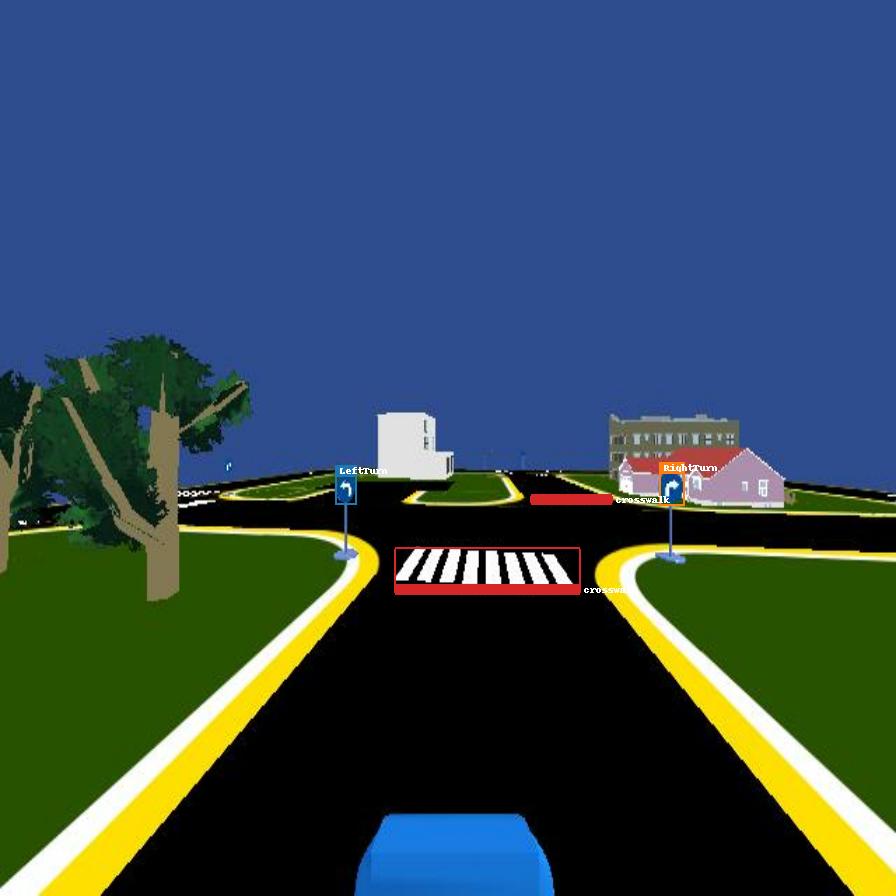

In [13]:
# image 및 label 함께 확인 시각화
image, (labels, bbs) = next(iter(ds))

image_n = efficientdet.data.preprocess.unnormalize_image(image)

labels_name = [classes[l] for l in labels.numpy().tolist()]
colors = efficientdet.visualizer.colors_per_labels(labels_name)

efficientdet.visualizer.draw_boxes(image_n, bbs, labels_name, colors=colors)

train, validation dataset 나누기

In [14]:
train_ds = ds
valid_ds = val_ds

# Data augmentation on training set
train_ds = (train_ds
             .map(efficientdet.augment.RandomCrop())
             .map(efficientdet.augment.RandomVerticalFlip())
             .map(efficientdet.augment.RandomZoom())
             .map(efficientdet.augment.RandomCutMix())
             )



In [15]:
batch_size = 1 #@param {type: "slider", min: 1, max: 64}

In [16]:
padded_image_shape = (*im_size, 3)
padded_labels_shape = (None,)
boxes_padded_shape = (None, 4)

train_ds = train_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

valid_ds = valid_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape,
                                                (padded_labels_shape,
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

In [17]:
wrapped_train_ds = efficientdet.wrap_detection_dataset(
        train_ds, im_size=im_size, num_classes=len(class2idx))

wrapped_valid_ds = efficientdet.wrap_detection_dataset(
        valid_ds, im_size=im_size, num_classes=len(class2idx))

## Training

In [18]:
# epochs = 1000 #@param {type: "slider", min: 2, max: 3000}

# #@markdown Compute COCO mAP every `valdiate_freq` epochs
# valdiate_freq = 10 #@param {type: "slider", min: 1, max: 10}

VOC2007 데이터 셋에서 사전 훈련된 가중치를 사용하여 EfficientDet 사용

5개 parameter 설정
- `D`: EfficientDet 모델 선택
- `num_classes`: 데이터 세트에서 사용 가능한 클래스 `len(class2idx)`.
- `training_mode`: 학습할 때 'True'로 설정합니다.

In [19]:
#  model = efficientdet.EfficientDet(D=D,
#                                    num_classes=len(class2idx),
#                                    training_mode=True)

# checkpoint = tf.train.Checkpoint(model=model)
# checkpoint.restore('/content/drive/MyDrive/산학/pretrained/efficientdet-d3/model')

optimizer, optimizer scheduler 로드

In [20]:
# max_lr = 3e-4
# warmup_epochs = 10 # warmup epochs, adjust this based on your experience
# annealing_epochs = 200 # annealing epochs, set this near where early stopping usually occurs
# alpha = 0.001 / max_lr # calculates eta_min

# steps_per_epoch = sum(1 for _ in wrapped_train_ds)

# # Create scheduler
# lr = efficientdet.optim.WarmupCosineAnnealingLRScheduler(
#             max_lr=max_lr,
#             warmup_steps=warmup_epochs * steps_per_epoch,
#             total_steps=1000 * steps_per_epoch, # total steps for all epochs
#             annealing_steps=annealing_epochs * steps_per_epoch, # annealing steps
#             alpha=alpha)

# optimizer = tfa.optimizers.AdamW(learning_rate=lr,
#                                  weight_decay=4e-5)

model complie 및 model trian

In [21]:
# clf_loss = efficientdet.losses.EfficientDetFocalLoss()
# reg_loss = efficientdet.losses.EfficientDetHuberLoss()

# model.compile(loss=[reg_loss, clf_loss],
#               optimizer=optimizer, loss_weights=[1.0, 0.8])

# model.build([None, *im_size, 3])
# model.summary()

In [22]:
# # model train

# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint

# callbacks = [
#     efficientdet.callbacks.COCOmAPCallback(valid_ds,
#                                            class2idx,
#                                            validate_every=valdiate_freq),
#     EarlyStopping(
#     monitor='val_loss',
#     patience=80,
#     restore_best_weights=True),

#     ModelCheckpoint(
#     '/content/drive/MyDrive/산학/best_model/best_model_D3',  # 모델 가중치를 저장할 파일 경로
#     monitor='val_loss',  # 검증 세트의 손실을 모니터링
#     save_best_only=True,  # 가장 성능이 좋았던 시점의 가중치만을 저장
#     save_weights_only=True
# )
# ]

# with tf.device("/device:GPU:0"):
#     history = model.fit(wrapped_train_ds,
#             validation_data=wrapped_valid_ds,
#             epochs=epochs,
#             callbacks=callbacks)

# Inference

In [23]:
# 가중치 불러오기
model = efficientdet.EfficientDet(D=D,
                                   num_classes=len(class2idx),
                                   training_mode=False)

model.load_weights('/content/drive/MyDrive/산학/best_model_D3/best_model_D3')

coco_callback = efficientdet.callbacks.COCOmAPCallback(valid_ds, class2idx)

# compute mAP for the final model
coco_callback.set_model(model)
coco_callback.on_epoch_end(epoch=0)

44107200/44107200 [==============================] - 3s 0us/step
creating index...
index created!
Validating[0/18]...
Validating[10/18]...
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all |

`training_mode`를 `False`로 설정하고 `score_threshold`를 변경하면서 조정

#Inference Time

In [24]:
model.training_mode = True
model.filter_detections.score_threshold = 0.5

In [41]:
import time

# Initialize variables
total_time = 0
num_batches = 0

# Create a iterator for the dataset
iter_ds = iter(wrapped_valid_ds)

# Warm-up prediction to avoid including initialization time
with tf.device("/device:GPU:0"):
    _ = model.predict(next(iter_ds)[0])  # Warm-up prediction

for batch in iter_ds:

    start_time = time.time()

    with tf.device("/device:GPU:0"):
        predictions = model.predict(batch[0])  # batch[0] contains the images
        filtered_bboxes, filtered_labels, filtered_scores = model.filter_detections(batch[0], predictions[0], predictions[1])
        print(filtered_labels)

    # End time
    end_time = time.time()

    # Calculate inference time for this batch and add to total time
    total_time += (end_time - start_time)
    num_batches += 1

# Calculate average inference time
average_inference_time = total_time / num_batches

print(f"Average inference time per batch: {average_inference_time} seconds")

average_inference_time_per_image = average_inference_time / batch_size
print(f"Average inference time per image: {average_inference_time_per_image} seconds")

1/1 [==============================] - 0s 112ms/step
[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 3], dtype=int32)>]
1/1 [==============================] - 0s 95ms/step
[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 3], dtype=int32)>]
1/1 [==============================] - 0s 91ms/step
[<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>]
1/1 [==============================] - 0s 90ms/step
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 1, 3], dtype=int32)>]
1/1 [==============================] - 0s 90ms/step
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 0, 1, 3], dtype=int32)>]
1/1 [==============================] - 0s 90ms/step
[<tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>]
1/1 [==============================] - 0s 88ms/step
[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 2, 3], dtype=int32)>]
1/1 [==============================] - 0s 83ms/step
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 

# Inference 시각화

In [27]:
model.training_mode = False
model.filter_detections.score_threshold = 0.5 # 0.55이상인 모든 bbox를 표현함

Inference Time: 0.7583827972412109 seconds


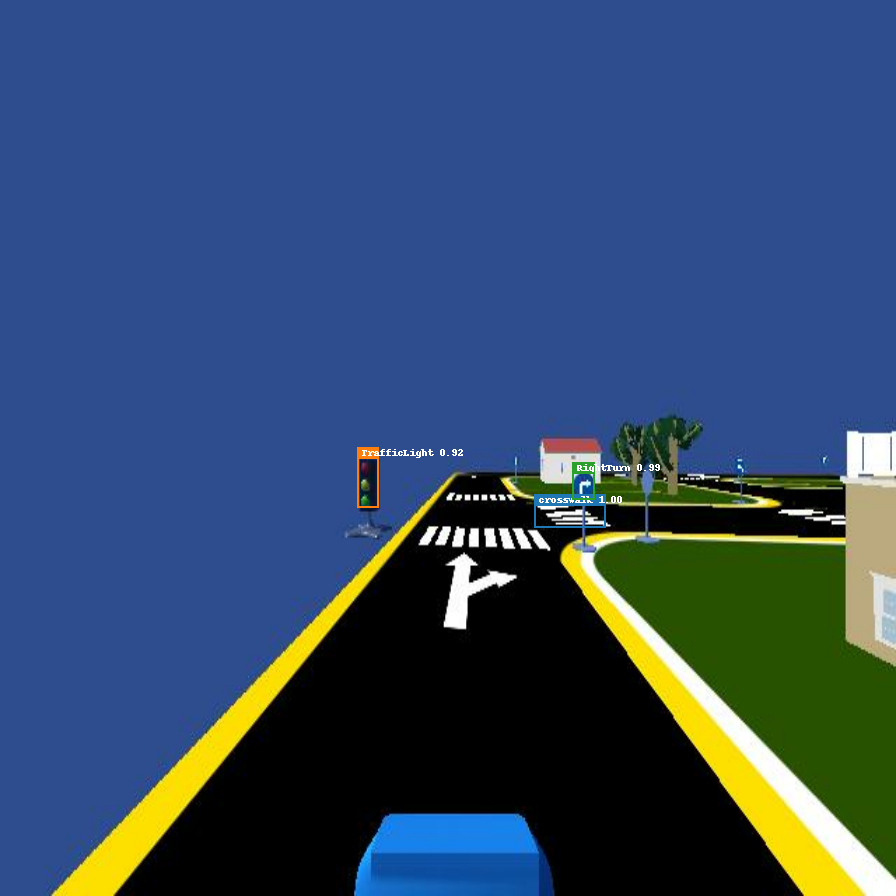

In [37]:
import time

# random image 1장에 대한 예측 시각화
image, _ = next(iter(valid_ds.unbatch().shuffle(42).take(2)))

# 추론 시간 측정
start_time = time.time()

# 모델 추론
bbs, labels, scores = model(tf.expand_dims(image, axis=0), training=False)

end_time = time.time()
inference_time = end_time - start_time

print("Inference Time:", inference_time, "seconds")

# Normalize the image
image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Convert dataset labels to names
labels_name = [classes[l] for l in labels[0].numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drawn boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(
    image_n, bbs[0], labels_name, scores=scores[0], colors=colors)


In [29]:
import time

# Initialize variables
total_time = 0
num_images = 0

# Create a iterator for the dataset
iter_ds = iter(valid_ds.unbatch().shuffle(42))

# Warm-up prediction
image, _ = next(iter_ds)
with tf.device("/device:GPU:0"):
    _ = model(tf.expand_dims(image, 0), training=False)

# Iterating over the rest of the dataset
for image, _ in iter_ds:

    # Start time
    start_time = time.time()

    # Inference
    with tf.device("/device:GPU:0"):
        bbs, scores = model(tf.expand_dims(image, 0), training=True)

    # End time
    end_time = time.time()

    # Calculate inference time for this image and add to total time
    inference_time = end_time - start_time
    total_time += inference_time
    num_images += 1

    print(f"Inference time for image {num_images}: {inference_time} seconds")

# Calculate average inference time
average_inference_time = total_time / num_images

print(f"Average inference time per image: {average_inference_time} seconds")


ValueError: ignored

In [ ]:
bbs

In [ ]:
labels

In [ ]:
scores